In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.environ['DH_DIR'])

import numpy as np
from scipy import integrate
import pickle

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

## 0. utilities

In [2]:
# constants
EPSILON = 1e-100
Mpc = 3.08568e24 # cm

# utilities
def logspace(a, b, n):
    arr = np.logspace(np.log10(a), np.log10(b), n)
    arr[0] = a
    arr[-1] = b
    return arr
def range_wend(a, b, step=1):
    return range(int(a), int(b+1), step)

# plotting
def tento_label(expns):
    return [r'$10^{'+str(expn)+r'}$' for expn in expns]

## 1. photon cross sections & rates

$$\Gamma_\text{int}=\frac{dN}{dt}=nc\int\frac{d\sigma}{dE'}\Big|_{E'}dE'$$
$$\Gamma_\text{cool}\equiv t_\text{cool}^{-1}=\left|\frac{d\log E}{dt}\right|=\frac{1}{E}\left|\frac{dE}{dt}\right|=\frac{nc}{E}\int|\Delta E'|\frac{d\sigma}{dE'}\Big|_{E'}dE'$$

In [3]:
def pp_CMB_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    
    # Ep: hard, ep: soft
    epmin = (1+1e-10) * phys.me**2 / Ep
    epmax = 500*phys.TCMB(rs)
    if epmax <= epmin:
        return 0
    eng_CMB = logspace(epmin, epmax, 100) # eV
    eng_CMB_binbounds = spectools.get_bin_bound(eng_CMB) # eV
    eng_CMB_binwidths = eng_CMB_binbounds[1:] - eng_CMB_binbounds[:-1] # eV
    dndE_CMB = phys.CMB_spec(eng_CMB, phys.TCMB(rs)) # cm^-3 eV^-1
    dN_dEdt_arr = [] # eV^-1 s^-1
    
    for ep, dndE in zip(eng_CMB, dndE_CMB):
        
        E = Ep / phys.me # 1(E/me) | input hard photon energy
        e = ep / phys.me # 1(E/me) | CMB soft photon energy
        A = E + e
        
        def integrand(Ee): # 1(1) | Ee in units of me | numerical factor in parentheses in Eq.(C1) in 0906.1197
            return ( (4*A**2*np.log(4*e*Ee*(A-Ee)/A)) / (Ee*(A-Ee))
                     - 8*e*A + (2*(2*e*A-1)*A**2) / (Ee*(A-Ee))
                     - (1-1/(e*A))*(A**4)/(Ee**2*(A-Ee)**2) )
#         intg, err = integrate.quad(integrand, A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))))
#         if np.abs(err/intg) > 1e-5:
#             raise ValueError('Large integration error.')
        xs = np.linspace(A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))), 100)
        intg = np.trapz(integrand(xs), xs)
        # dN/dEdt | eV^-1 s^-1 = cm^2 * cm/s * 1 * cm^-3 eV^-1
        dN_dEdt = phys.thomson_xsec * phys.c * (3/64) * (1/(e**2 * E**3)) * intg * dndE
        dN_dEdt_arr.append(dN_dEdt)
        
    rate = np.dot(dN_dEdt_arr, eng_CMB_binwidths) # s^-1
    return rate

In [4]:
def pp_matter_rate(Ep, rs, xHII=None, xHeII=None, xHeIII=None): # s^-1(eV, 1) | vectorized in Ep
    
    if xHII is None:
        xHII = phys.xHII_std(rs)
    if xHeII is None:
        xHeII = phys.xHeII_std(rs)
    if xHeIII is None:
        xHeIII = 0
        
    ref_rate = phys.alpha * phys.ele_rad**2 * phys.c * phys.nH * rs**3 # s^-1 = cm^2 * cm/s * cm^-3 | reference cross section
    
    # rate s^-1 = cm^2 * cm/s * cm^-3
    rate_xHII   = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHII
    rate_xHeII  = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHeII
    rate_xHeIII = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(218/27), 0, None) * xHeIII # placeholder
    rate_elec   = ref_rate * np.clip((28/9)*np.log(2*Ep/phys.me)-(100/9),  0, None) * (xHII + xHeII + 2*xHeIII)
    rate_xHI    = ref_rate * 5.4  * np.log(513*Ep/(Ep+825*phys.me)) * (1 - xHII)
    rate_xHeI   = ref_rate * 8.76 * np.log(513*Ep/(Ep+825*phys.me)) * (phys.nHe/phys.nH - xHeII - xHeIII)
    return rate_xHII + rate_xHeII + rate_xHeIII + rate_elec + rate_xHI + rate_xHeI

### pair production on fully ionized matter
1989ApJ...344..551Z (Zdziarski and Svensson 1989, Eq.5.9-10)
$$\frac{d\tau}{dl}=\frac{d\tau}{c_0dt}=\frac{1}{c_0}\Gamma=n_\text{target}\sigma$$
$$\frac{d\tau}{d\tilde{l}}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2\frac{c_0}{H_0}\left(\log2\epsilon-\frac{109}{42}\right)$$
where, $d\tilde l = \frac{H_0}{c_0}dl$, $\epsilon = E/m_e$, $\alpha_f=1/137$, $r_0$ is electron classical radius.
$$\Gamma=c_0\frac{d\tau}{dl}=c_0\frac{H_0}{c_0}\frac{d\tau}{d\tilde l}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2c_0\left(\log2\epsilon-\frac{109}{42}\right)$$

In [6]:
def pp_matter_fullion_ZS_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    # s^-1 = cm^3 * cm^2 * cm s^-1
    rate = 20/3 * (phys.nH+2*phys.nHe) * rs**3 * phys.alpha * phys.ele_rad**2 * phys.c * \
           (np.log(2*Ep/phys.me) - 109/42)
    return np.clip(rate, 0, None)

In [5]:
def phph_scat_rate(Ep, rs, **kwargs): # s^-1(eV, 1) | vectorized in Ep
    # s^-1 = 1 * s^-1 * 1
    return 1.83e-27 * (2*phys.h)**(-1) * (phys.TCMB(1)/(2.7*phys.kB))**6 \
           * phys.H0 * rs**6 * (Ep/phys.me)**3

def phph_scat_cool_rate(Ep, rs, **kwargs): # s^-1(eV, 1) | vectorized in Ep
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return (1-(Ef/E)+(Ef/E)**2)**2 * (E-Ef)
    intg, err = integrate.quad(integrand, E/2, E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    return phph_scat_rate(Ep, rs) * (20/7) * intg / E**2

In [8]:
def compton_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return Ef/E + E/Ef - 1 + (1 - (1/Ef - 1/E))**2
    intg, err = integrate.quad(integrand, E/(1+2*E), E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    sigma = np.pi * phys.alpha**2 * (phys.ele_compton/(2*np.pi))**2 * (1/E**2) * intg # cm^2
#     if E < 1:
#         sigma *= E
    return sigma * phys.c * (phys.nH + 2*phys.nHe) * rs**3

def compton_cool_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    E = Ep/phys.me
    def integrand(Ef): # 1(1)
        return (Ef/E + E/Ef - 1 + (1 - (1/Ef - 1/E))**2) * (E-Ef)
    intg, err = integrate.quad(integrand, E/(1+2*E), E)
    if np.abs(err/intg) > 1e-5:
        raise ValueError('Large integration error.')
    sigma = np.pi * phys.alpha**2 * (phys.ele_compton/(2*np.pi))**2 * (1/E**2) * intg / E # cm^2
    return sigma * phys.c * (phys.nH + 2*phys.nHe) * rs**3

In [9]:
def photoion_rate(Ep, rs, xHII=None, xHeII=None): # s^-1(eV, 1)
    
    if xHII is None:
        xHII = phys.xHII_std(rs)
    if xHeII is None:
        xHeII = phys.xHeII_std(rs)
    
    def sigma_1e(E, Eth): # cm^2(eV, eV)
        if E <= Eth:
            return 0
        eta = 1/(np.sqrt(E/Eth) - 1)
        return (2**9*np.pi**2*phys.ele_rad**2)/(3*phys.alpha**3) * (Eth/E)**4 \
               * np.exp(-4*eta*np.arctan(1/eta)) / (1 - np.exp(-2*np.pi*eta))
    
    def sigma_HeII(E): # cm^2(eV)
        if E < 50: # eV
            return 0
        expn = -3.30 if E > 250 else -2.65
        return -12*sigma_1e(E, 13.6) + 5.1e-20 * (E/250)**expn # cm^2
    
    rate_xHI   = sigma_1e(Ep, 13.6) * phys.c * phys.nH * rs**3 * (1 - xHII)
    rate_xHeII = sigma_1e(Ep, 54.4) * phys.c * phys.nH * rs**3 * xHeII
    rate_xHeI  = sigma_HeII(Ep) * phys.c * phys.nH * rs**3 * (phys.nHe/phys.nH - xHeII)
    
    return rate_xHI + rate_xHeII + rate_xHeI

### 1.1 plot rates

In [9]:
# define grid
Ep_log10lim = (2, 13)
rs_log10lim = (0, 3.5)
Ep_s = np.logspace(*Ep_log10lim, 100)
rs_s = np.logspace(*rs_log10lim, 100)
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Ep_s)))
a_ss      = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

In [15]:
# calculate rates
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, phph_scat_cool_rate,
         compton_rate, compton_cool_rate, photoion_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = {}
    for func in funcs:
        name = func.__name__
        print(key, name, flush=True)
        rate_ss = []
        for rs in tqdm(rs_s):
            rate_s = []
            xHeII = xHII * phys.nHe/phys.nH
            for Ep in Ep_s:
                rate_s.append(func(Ep, rs, xHII=xHII, xHeII=xHeII))
            rate_ss.append(rate_s)
        rate_ss_dict[key][name] = rate_ss.copy()

xHII=1e-4 pp_CMB_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 pp_matter_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 phph_scat_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 phph_scat_cool_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 compton_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 compton_cool_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1e-4 photoion_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 pp_CMB_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 pp_matter_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 phph_scat_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 phph_scat_cool_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 compton_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 compton_cool_rate


  0%|          | 0/100 [00:00<?, ?it/s]

xHII=1-1e-4 photoion_rate


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# save rates
pickle.dump(rate_ss_dict, open('rates/photon_rates_dict.p', 'wb'))

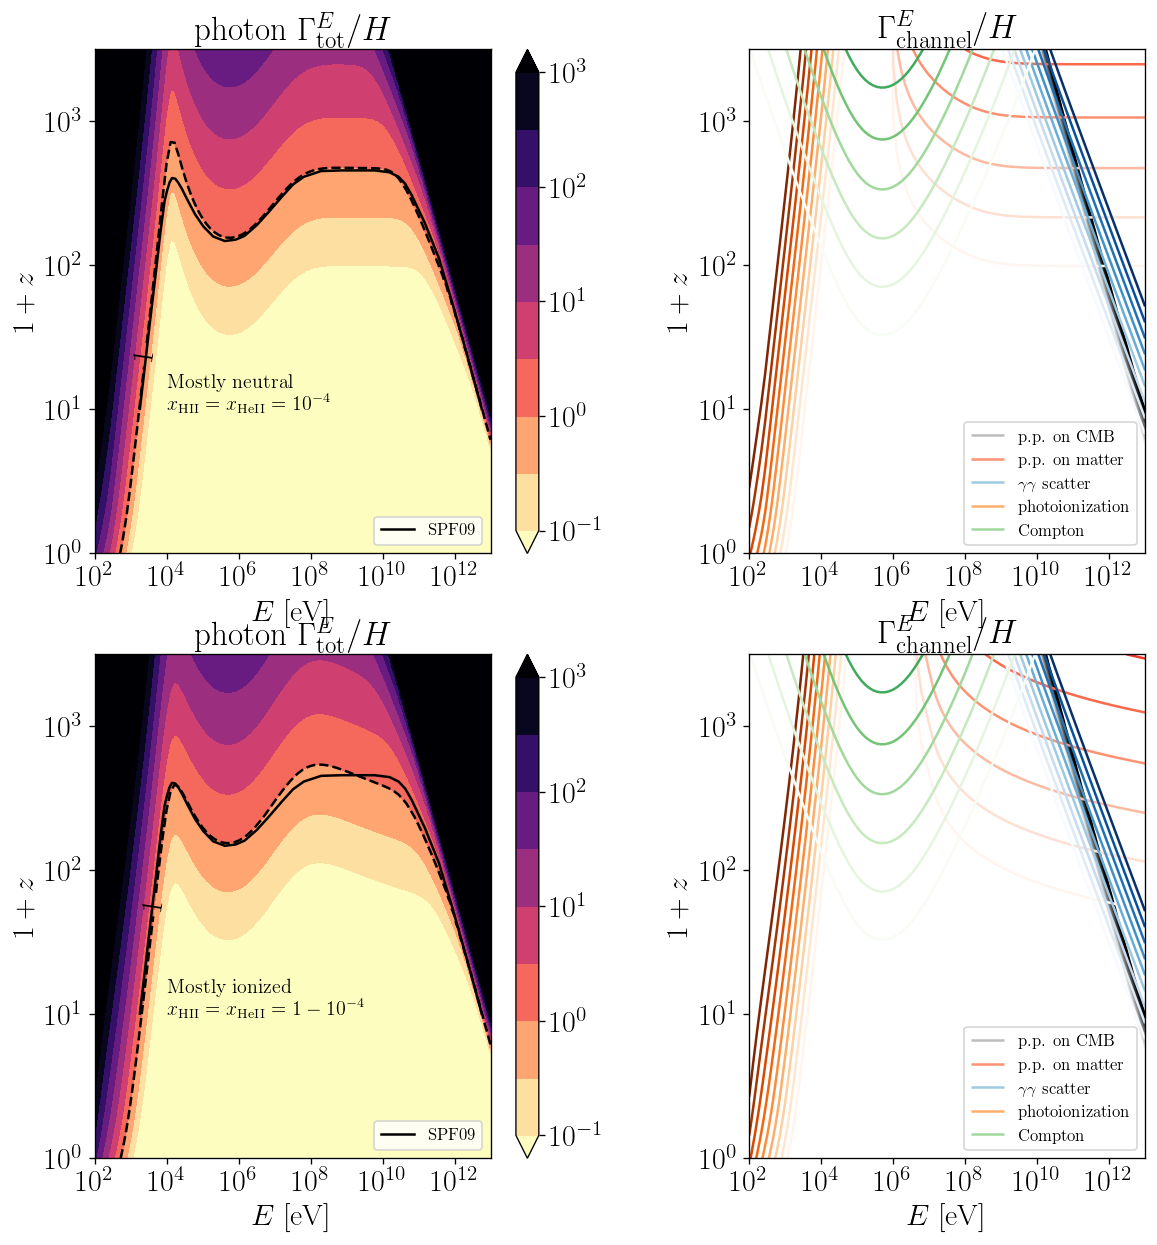

In [31]:
# plot rates
plot_cool = True
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    
    if plot_cool:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_cool_rate]
        title_left = r'photon $\Gamma^E_\mathrm{tot}/H$'
        title_right = r'$\Gamma^E_\mathrm{channel}/H$'
    else:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_rate]
        title_left  = r'photon $\Gamma_\mathrm{tot}/H$'
        title_right = r'$\Gamma_\mathrm{channel}/H$'
    
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]
    ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)

    levels = np.linspace(-1, 3, 9)
    im = axs[ik,0].contourf(x_ss, y_ss, np.log10(ratio), cmap='magma_r', levels=levels, extend='both')
    cs = axs[ik,0].contour( x_ss, y_ss, np.log10(ratio), colors='k', linestyles='--',
                            levels=np.log10([1]), extend='both')
    axs[ik,0].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
    cbar = fig.colorbar(im, ax=axs[ik,0], spacing='proportional', ticks=range_wend(-1, 3))
    cbar.ax.set_yticklabels(tento_label(range_wend(-1, 3)))
    if plot_cool:
        x_t, y_t = np.loadtxt('rates/SPF09/tcool_tH_1.txt', unpack=True)
        axs[ik,0].plot(x_t, y_t, 'k', label='SPF09')
        axs[ik,0].legend(loc='lower right', fontsize=10)
    axs[ik,0].set_aspect(4)
    axs[ik,0].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik,0].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik,0].set_yticks(range_wend(*rs_log10lim))
    axs[ik,0].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,0].set(title=title_left, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')

    labels = ['p.p. on CMB', 'p.p. on matter', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton']
    cmaps = ['Greys', 'Reds', 'Blues', 'Oranges', 'Greens']
    for i, rate in enumerate(rates):
        ratio = np.clip(rate, 1e-100, None) / np.array(hubble_ss)
        cs = axs[ik,1].contour(x_ss, y_ss, np.log10(ratio), cmap=cmaps[i], levels=levels, extend='both')
        if i != 20:
            cs.collections[3].set_label(labels[i])
    axs[ik,1].set_aspect(4)
    axs[ik,1].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik,1].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik,1].set_yticks(range_wend(*rs_log10lim))
    axs[ik,1].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,1].set(title=title_right, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    axs[ik,1].legend(fontsize=10, loc='lower right')
    
    axs[ik,0].text(4, 1, textstr, fontsize=12, color='k')
    
    # if plot_cool:
    #     fig.savefig('cool_rate.pdf')
    # else:
    #     fig.savefig('int_rate.pdf')

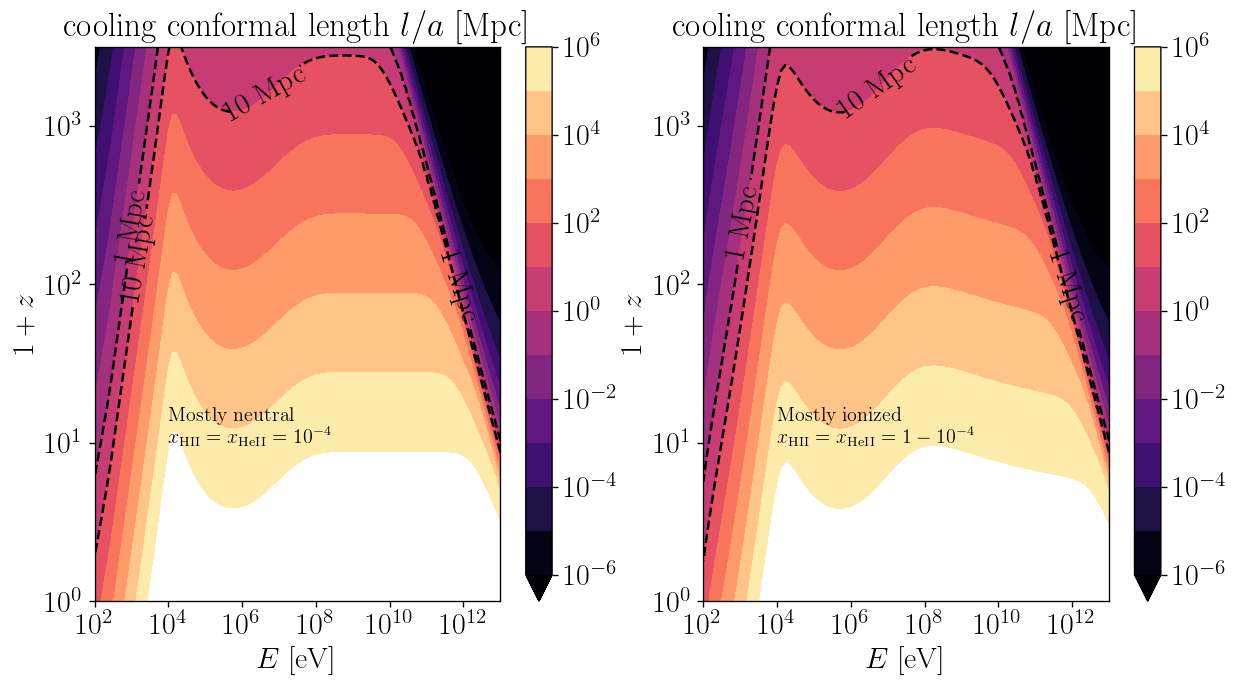

In [39]:
# plot optical depth
plot_cool = True
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    
    if plot_cool:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_cool_rate]
    else:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_rate]
    title = r'cooling conformal length $l/a$ [Mpc]'
    
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]

    Mpc = 3.08568e24 # cm
    cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(4, 1, textstr, fontsize=12, color='k')

#     if plot_cool:
#         fig.savefig('cool_cfm_length.pdf')
#     else:
#         fig.savefig('int_cfm_length.pdf')

### 1.2 rates at one slice

In [40]:
Ep_s = logspace(1e3, 1e12, 100)
rs = 1001
rate_ss = []
for func in [pp_CMB_rate, phph_scat_rate, photoion_rate, compton_cool_rate,
             lambda Ep, rs: pp_matter_rate(Ep, rs, 1, 0, phys.nHe/phys.nH),
             lambda Ep, rs: pp_matter_rate(Ep, rs, 0, 0, 0),
             pp_matter_fullion_ZS_rate]:
    rate_ss.append([func(Ep, rs) for Ep in Ep_s])
    print('.', end='', flush=True)
rate_ss = np.array(rate_ss)
ratio_ss = rate_ss / phys.hubble(rs)

.......

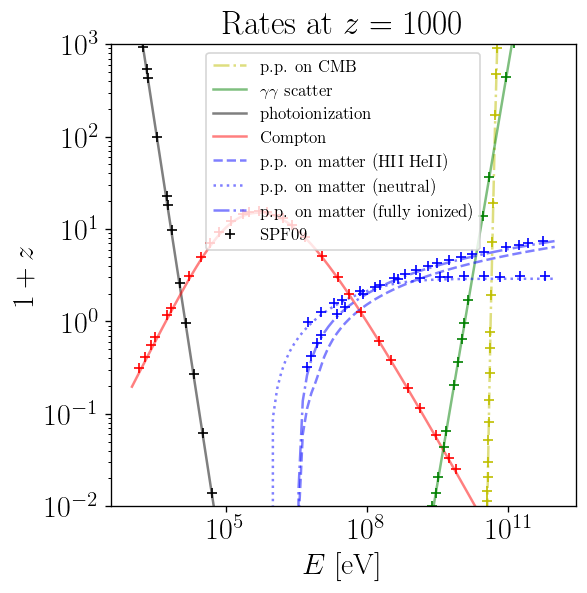

In [42]:
# plot optical depth
fig, ax = plt.subplots(figsize=(5,5))

plot_cool = True
if plot_cool:
    title = r'photon $\Gamma^E_\mathrm{tot}/H$ at $z=1000$'
else:
    title = r'photon $\Gamma_\mathrm{tot}/H$ at $z=1000$'

styles     = ['y-.', 'g-', 'k-', 'r-', 'b--', 'b:', 'b-.']
styles_spf = ['y+',  'g+', 'k+', 'r+', 'b+',  'b+', 'b+' ]
spf_fns = ['pp_CMB', 'phph_scat', 'photoion', 'compton', 'pp_matter_HII_HeII', 'pp_matter_neutral']
labels = ['p.p. on CMB', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton',
          'p.p. on matter (HII HeII)', 'p.p. on matter (neutral)', 'p.p. on matter (fully ionized)']

labels_spf = ['', '', 'SPF09', '', '', '', '']

for i in range(7):
    ax.plot(Ep_s, ratio_ss[i], styles[i], label=labels[i], alpha=0.5)
for i in range(6):
    x, y = np.loadtxt('rates/SPF09/'+spf_fns[i]+'.txt', unpack=True)
    ax.plot(10**x, 10**y, styles_spf[i], label=labels_spf[i])
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e-2,1e3))
ax.legend(fontsize=10)

ax.set(title=r'Rates at $z=1000$', xlabel=r'$E$ [eV]', ylabel=r'$1+z$');
# fig.savefig('z1000rates.pdf')

## 2. electron rates

In [3]:
# rates in Furlanetto 0910.4410
year = 365.25*86400 # [s]

def ee_coll_rate(Eek, rs, xHII=None, use_tcool_approx=False): # [s^-1]([eV], [1], [1])
    
    xe = phys.xHII_std(rs) + phys.xHeII_std(rs) if xHII is None else xHII
    
    if use_tcool_approx:
        tcool = 5e3 * year * (1/xe) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
        rate = 1 / tcool
    else:
        dEdt = phys.elec_heating_engloss_rate(Eek, xe, rs) # [eV/s]
        rate = dEdt / Eek # [1/s]
        
    return rate

def e_ion_rate(Eek, rs, xHII=None): # [s^-1]([eV], [1], [1])
    xHI = 1 - (xHII if xHII is not None else phys.xHII_std(rs))
    tcool = 5e5 * year * (1/xHI) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
    return 1/tcool

def e_exc_rate(Eek, rs, xHII=None): # [s^-1]([eV], [1], [1])
    return e_ion_rate(Eek, rs, xHII=xHII)

def e_ics_rate(Eek, rs, *args): # [s^-1]([eV], [1])
    gamma = (Eek + phys.me)/phys.me
    tcool = 1e8 * year * (rs/10)**(-4) / gamma**2
    return 1/tcool

### 2.1 plot rates

In [4]:
# define grid
Eek_log10lim = (1, 9)
rs_log10lim  = (0, 2)
Eek_s = np.logspace(*Eek_log10lim, 100)
rs_s  = np.logspace(*rs_log10lim, 100)
x_ss, y_ss = np.meshgrid(np.log10(Eek_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Eek_s)))
a_ss      = np.zeros((len(rs_s), len(Eek_s)))
for i, rs in enumerate(rs_s):
    for j, Eek in enumerate(Eek_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

In [5]:
# calculate rates
funcs = [ee_coll_rate, e_ion_rate, e_exc_rate, e_ics_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = []
    for func in funcs:
        rate_ss = []
        for rs in rs_s:
            rate_s = []
            for Eek in Eek_s:
                rate_s.append(func(Eek, rs, xHII))
            rate_ss.append(rate_s)
        rate_ss_dict[key].append(rate_ss)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


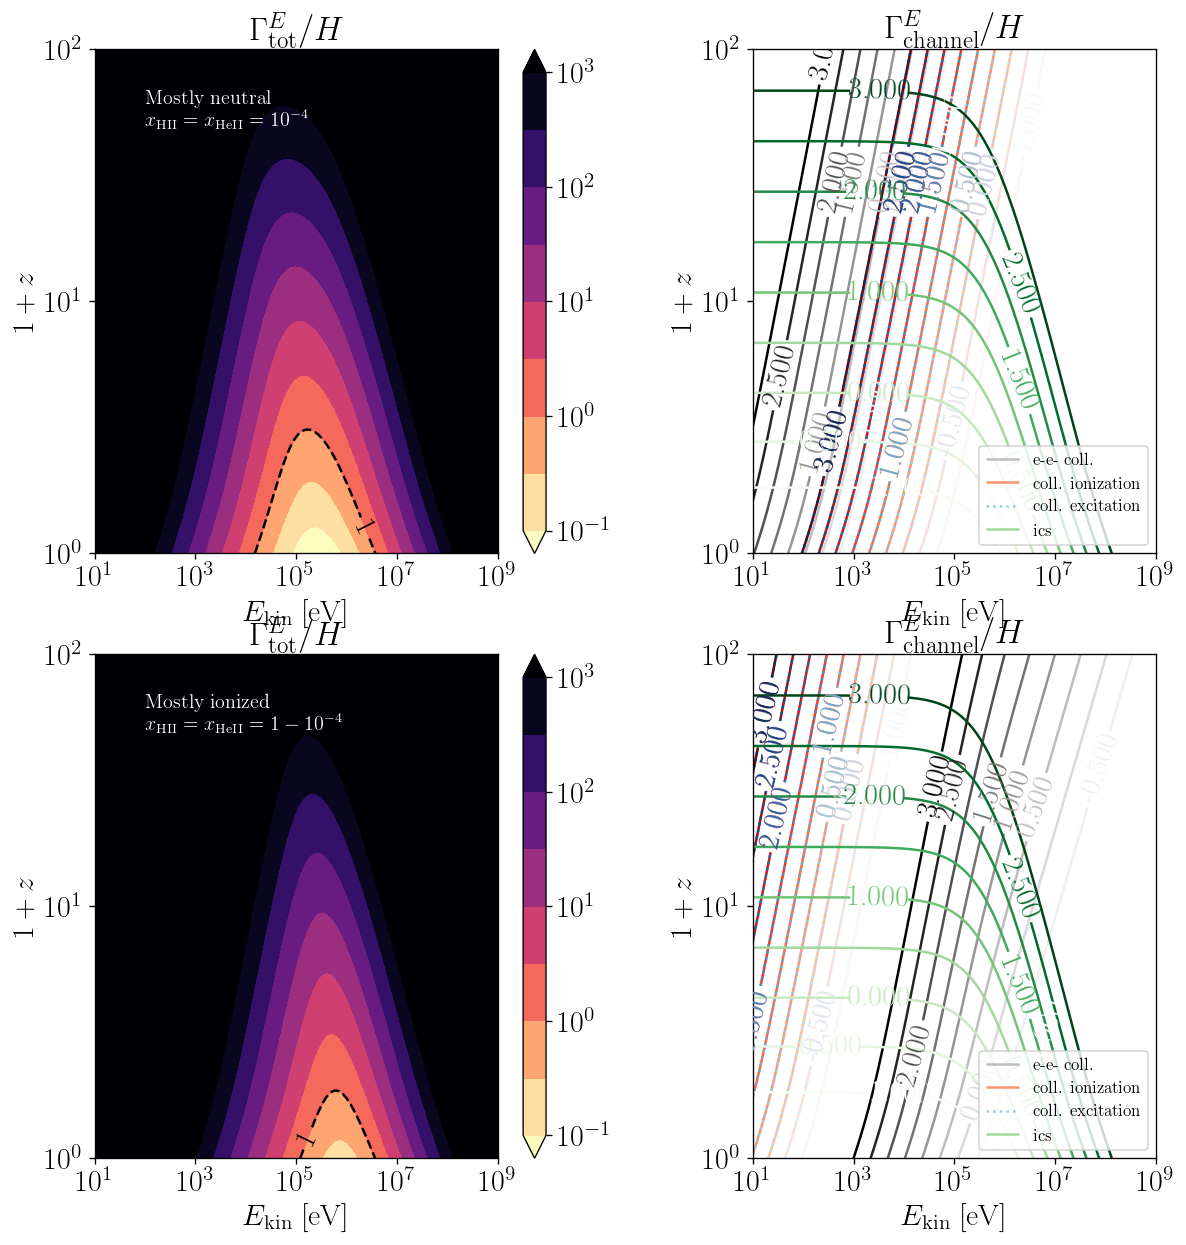

In [6]:
# plot rates
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title_left = r'$\Gamma^E_\mathrm{tot}/H~$'
    title_right = r'$\Gamma^E_\mathrm{channel}/H~$'

    rates = rate_ss_dict[key]
    ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)

    levels = np.linspace(-1, 3, 9)
    im = axs[ik,0].contourf(x_ss, y_ss, np.log10(ratio), cmap='magma_r', levels=levels, extend='both')
    cs = axs[ik,0].contour( x_ss, y_ss, np.log10(ratio), colors='k', linestyles='--',
                         levels=np.log10([1]), extend='both')
    axs[ik,0].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
    
    cbar = fig.colorbar(im, ax=axs[ik,0], spacing='proportional', ticks=range_wend(-1, 3))
    cbar.ax.set_yticklabels(tento_label(range_wend(-1, 3)))

    axs[ik,0].set_aspect(5)
    axs[ik,0].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik,0].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik,0].set_yticks(range_wend(*rs_log10lim))
    axs[ik,0].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,0].set(title=title_left, xlabel=r'$E_\mathrm{kin}$ [eV]', ylabel=r'$1+z$')

    labels = ['e-e- coll.', 'coll. ionization', 'coll. excitation', 'ics']
    cmaps = ['Greys', 'Reds', 'Blues', 'Greens']
    for i, rate in enumerate(rates):
        ratio = np.clip(rate, 1e-100, None) / np.array(hubble_ss)
        config = dict(cmap=cmaps[i], levels=levels, extend='both')
        if i == 2:
            config.update(linestyles=':')
        cs = axs[ik,1].contour(x_ss, y_ss, np.log10(ratio), **config)
        axs[ik,1].clabel(cs, cs.levels)
        if i != 20:
            cs.collections[3].set_label(labels[i])
    axs[ik,1].set_aspect(5)
    axs[ik,1].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik,1].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik,1].set_yticks(range_wend(*rs_log10lim))
    axs[ik,1].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,1].set(title=title_right, xlabel=r'$E_\mathrm{kin}$ [eV]', ylabel=r'$1+z$')
    axs[ik,1].legend(fontsize=10, loc='lower right')
    
    axs[ik,0].text(2, 1.7, textstr, fontsize=12, color='w')

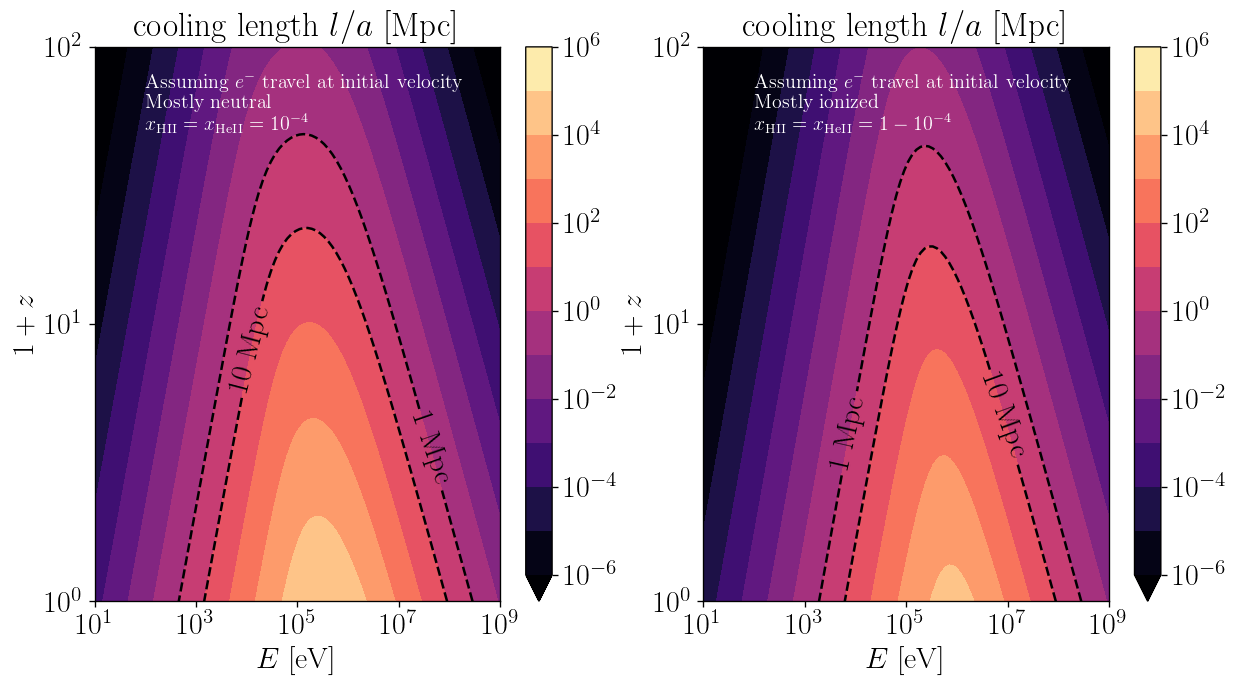

In [7]:
# plot scattering length
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title = r'cooling length $l/a$ [Mpc]'
    
    rates = rate_ss_dict[key]
    Mpc = 3.08568e24 # cm
    gamma = 1 + Eek_s / phys.me
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    cfdepth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(2, 1.7, 'Assuming $e^-$ travel at initial velocity\n'+textstr, fontsize=12, color='w')

In [21]:
# inverse scattering length
scat_length_ss = []
for rs in rs_s:
    scat_length_s = []
    for Eek in Eek_s:
        scat_length_s.append( 1/(phys.thomson_xsec * phys.CMB_N_density(phys.TCMB(rs))) )
    scat_length_ss.append(scat_length_s)
scat_length_ss = np.array(scat_length_ss)

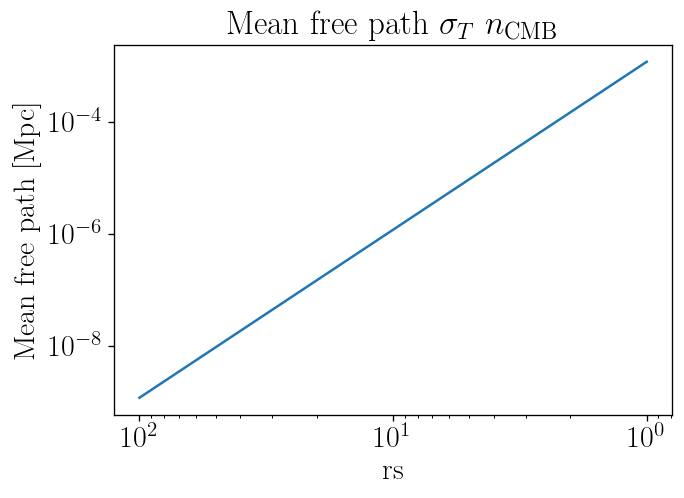

In [64]:
Mpc = 3.08568e24 # cm
inv_scat_l_s = [1/(phys.thomson_xsec * phys.CMB_N_density(phys.TCMB(rs)))/Mpc for rs in rs_s]

fig, ax = plt.subplots()
ax.plot(rs_s, inv_scat_l_s)
ax.invert_xaxis()
ax.set(xscale='log', yscale='log')
ax.set(xlabel='rs', ylabel='Mean free path [Mpc]', title=r'Mean free path $\sigma_T~n_\mathrm{CMB}$');

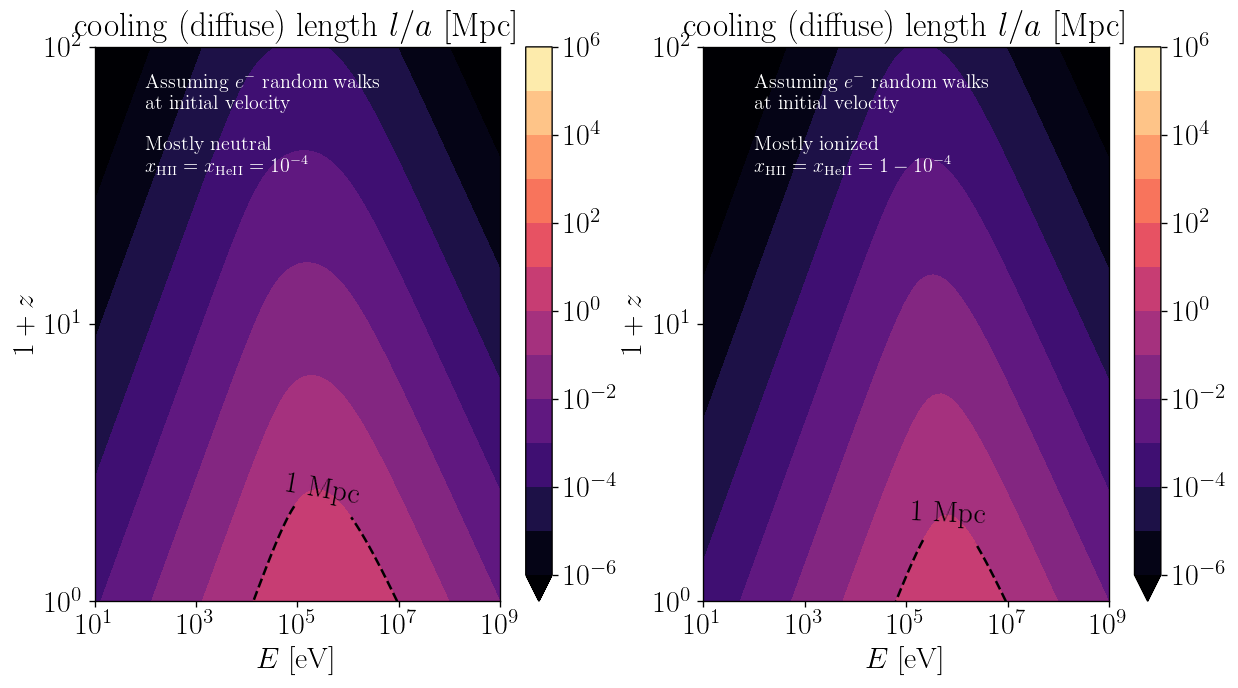

In [58]:
# plot scattering length
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title = r'cooling (diffuse) length $l/a$ [Mpc]'
    
    rates = rate_ss_dict[key]
    Mpc = 3.08568e24 # cm
    gamma = 1 + Eek_s / phys.me
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    depth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) # cm
    n_scat = depth / scat_length_ss
    depth = np.sqrt(n_scat) * scat_length_ss
    cfdepth = depth / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(2, 1.55, 'Assuming $e^-$ random walks \nat initial velocity\n\n'+textstr,
                 fontsize=12, color='w')

## Photon Optical depth

In [6]:
def d_integrand(rs): # cm
    return phys.c / (rs*phys.hubble(rs))

print('Distance', integrate.quad(d_integrand, 1, 1.15)[0] / Mpc, 'Mpc')

Distance 599.9078004161291 Mpc


In [10]:
def od_CMB_integrand(rs, Ep):
    return pp_CMB_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_CMB_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 4696.850949364589


In [11]:
def trapz_integrate(func, a, b, args=None, n=100):
    xs = np.linspace(a, b, n)
    fs = [func(x, *args) for x in xs]
    return np.trapz(fs, xs)

In [13]:
EBL_data = np.loadtxt('EBL_EdNdE.txt')
eng_EBL  = EBL_data[:, 0]
dndE_EBL = EBL_data[:, 1] / eng_EBL

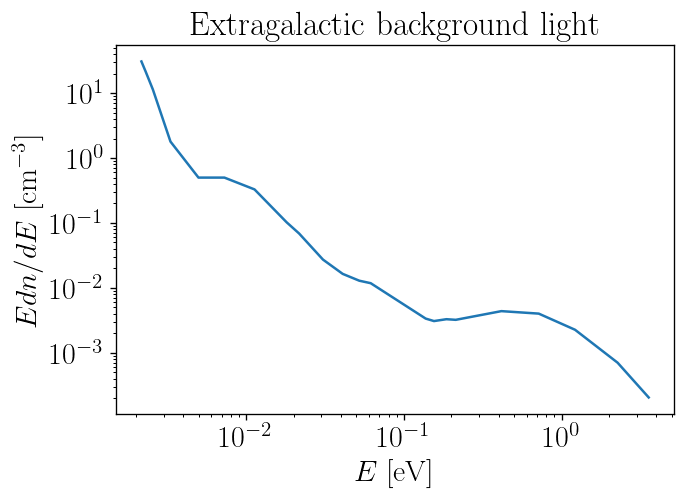

In [14]:
fig, ax = plt.subplots()
ax.plot(EBL_data[:,0], EBL_data[:,1])
ax.set(xlabel='$E$ [eV]', ylabel='$Edn/dE$ [cm$^{-3}$]', title='Extragalactic background light')
ax.set(xscale='log', yscale='log');

In [15]:
def pp_EBL_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    
    # Ep: hard, ep: soft
    emin = phys.me**2 / Ep
    i_st = np.searchsorted(eng_EBL, emin)
    #print(i_st)
    eng_binbounds = eng_EBL[i_st:] # eV
    dndE = dndE_EBL[i_st:]
    
    eng_center = (eng_binbounds[1:] + eng_binbounds[:-1]) / 2
    eng_binwidths = eng_binbounds[1:] - eng_binbounds[:-1] # eV
    dndE_center = (dndE[1:] + dndE[:-1]) / 2 # cm^-3 eV^-1
    dN_dEdt_arr = [] # eV^-1 s^-1
    
    for ep, dndE in zip(eng_center, dndE_center):
        
        E = Ep / phys.me # 1(E/me) | input hard photon energy
        e = ep / phys.me # 1(E/me) | soft photon energy
        A = E + e
        
        def integrand(Ee): # 1(1) | Ee in units of me | numerical factor in parentheses in Eq.(C1) in 0906.1197
            return ( (4*A**2*np.log(4*e*Ee*(A-Ee)/A)) / (Ee*(A-Ee))
                     - 8*e*A + (2*(2*e*A-1)*A**2) / (Ee*(A-Ee))
                     - (1-1/(e*A))*(A**4)/(Ee**2*(A-Ee)**2) )
#         intg, err = integrate.quad(integrand, A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))))
#         if np.abs(err/intg) > 1e-5:
#             raise ValueError('Large integration error.')
        xs = np.linspace(A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))), 100)
        #print(1-1/(E*e))
        intg = np.trapz(integrand(xs), xs)
        # dN/dEdt | eV^-1 s^-1 = cm^2 * cm/s * 1 * cm^-3 eV^-1
        dN_dEdt = phys.thomson_xsec * phys.c * (3/64) * (1/(e**2 * E**3)) * intg * dndE
        dN_dEdt_arr.append(dN_dEdt)
        
    rate = np.dot(dN_dEdt_arr, eng_binwidths) # s^-1
    return rate

In [17]:
def od_EBL_integrand(rs, Ep):
    return pp_EBL_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_EBL_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 759.1350746739472


In [18]:
def od_scat_CMB_integrand(rs, Ep):
    return phph_scat_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_scat_CMB_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 0.045058420941899706


In [25]:
Eps = np.logspace(np.log10(1e10), np.log10(1e15), 100)

ods_dict = {
    'pp_EBL': [],
    'pp_CMB': [],
    'scat_EBL': [],
    'scat_CMB': []
}

for Ep in tqdm(Eps):
    ods_dict['pp_EBL'].append(trapz_integrate(od_EBL_integrand, 1, 1.15, args=(Ep,)))
    ods_dict['pp_CMB'].append(trapz_integrate(od_CMB_integrand, 1, 1.15, args=(Ep,)))
    ods_dict['scat_CMB'].append(trapz_integrate(od_scat_CMB_integrand, 1, 1.15, args=(Ep,)))
    #ods_dict['scat_EBL'].append(trapz_integrate(od_scat_EBL_integrand, 1, 1.15, args=(Ep,)))

  0%|          | 0/100 [00:00<?, ?it/s]

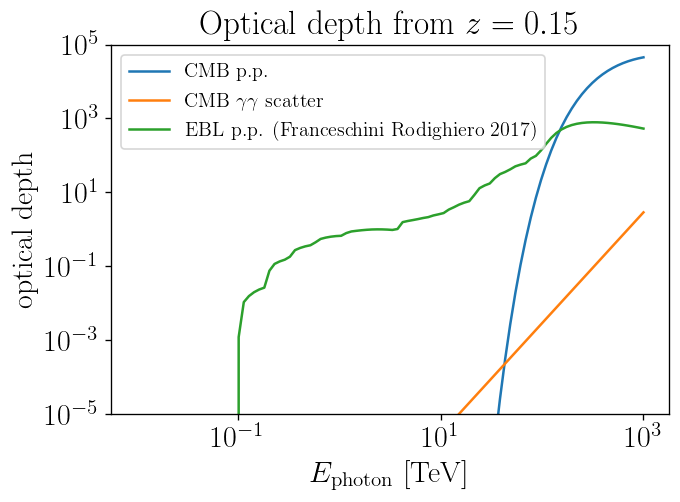

In [28]:
fig, ax = plt.subplots()
ax.plot(Eps/1e12, ods_dict['pp_CMB'], label='CMB p.p.')
ax.plot(Eps/1e12, ods_dict['scat_CMB'], label='CMB $\gamma\gamma$ scatter')
ax.plot(Eps/1e12, ods_dict['pp_EBL'], label='EBL p.p. (Franceschini Rodighiero 2017)')
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$E_\mathrm{photon}$ [TeV]', ylabel='optical depth', title='Optical depth from $z=0.15$')
ax.set(ylim=(1e-5, 1e5))
ax.legend(fontsize=12);

## Archive

In [ ]:
# darkhistory rate
hep_tf = pickle.load(open(os.environ['DH_DATA_DIR']+'/highengphot_tf_interp.raw', 'rb'))
dh_rate_ss = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in tqdm(enumerate(rs_s)):
    xH  = phys.xHII_std(rs)
    xHe = phys.xHeII_std(rs)
    tf = hep_tf.get_tf(xH, xHe, rs)
    for j, Ep in enumerate(Ep_s):
        
        i = np.searchsorted(hep_tf.eng, Ep)
        dl = Ep - hep_tf.eng[i]
        dh = hep_tf.eng[i+1] - Ep
        spec_data = np.zeros(len(hep_tf.eng))
        spec_data[i]   = dh/(dl+dh)
        spec_data[i+1] = dl/(dl+dh)
        in_spec = Spectrum(hep_tf.eng, spec_data, spec_type='N')
        in_E = in_spec.toteng()
        out_spec = tf.sum_spec()
        dh_rate_ss[i,j] = 0